In [84]:
import pandas as pd

# Step 1: Convert energy from millijoules (mJ) to joules (J)
def convert_energy_to_joules(df, energy_column):
    df[energy_column] = df[energy_column] / 1000  # Convert mJ to J
    return df

# Step 2: Normalize the energy by the simulation time (20000 milliseconds -> 20 seconds)
def normalize_energy(df, total_energy_column, simulation_time_sec=20):
    df['normalized_energy_per_sec'] = df[total_energy_column] / simulation_time_sec  # Normalize energy to J/s
    return df

# Step 3: Calculate the total energy (computation + networking) and total delay per scenario
def calculate_totals():
    # Summing computation energy per scenario and creating a new DataFrame
    total_computation_energy_df = computation_energy_df.groupby('scenario')['cmp_energy'].sum().reset_index()
    total_computation_energy_df.columns = ['scenario', 'total_computation_energy']

    # Summing networking energy per scenario and creating a new DataFrame
    total_networking_energy_df = networking_energy_df.groupby('scenario')['nw_energy'].sum().reset_index()
    total_networking_energy_df.columns = ['scenario', 'total_networking_energy']

    # Merge the two DataFrames to calculate the total energy per scenario
    total_energy_df = pd.merge(total_computation_energy_df, total_networking_energy_df, on='scenario')

    # Calculate total energy (computation + networking) per scenario
    total_energy_df['total_energy'] = total_energy_df['total_computation_energy'] + total_energy_df['total_networking_energy']

    # Group by 'scenario' and sum the delays
    total_delay_df = loop_delay_df.groupby('scenario')['delay'].sum().reset_index()
    total_delay_df.columns = ['scenario', 'total_delay']

    # Merge the total delay with the total_energy_df to include the delay data
    total_energy_df = pd.merge(total_energy_df, total_delay_df, on='scenario', how='left')

    # Convert energy from millijoules to joules (J)
    total_energy_df = convert_energy_to_joules(total_energy_df, 'total_computation_energy')
    total_energy_df = convert_energy_to_joules(total_energy_df, 'total_networking_energy')
    total_energy_df = convert_energy_to_joules(total_energy_df, 'total_energy')

    # Normalize the total energy per scenario
    total_energy_df = normalize_energy(total_energy_df, 'total_energy')

    # Sort by total energy in ascending order (lowest to highest energy)
    total_energy_df = total_energy_df.sort_values(by='total_energy', ascending=True).reset_index(drop=True)

    return total_energy_df

# Parse the label_pandas.txt file and calculate the totals
def parse(report_path='label_pandas.txt'):
    global Scenario, computation_energy_df, networking_energy_df, loop_delay_df

    with open(report_path, 'r') as file:
        for line in file:
            parse_scenario(line)
            parse_loops_delay(line)
            parse_simulation_time(line)
            parse_computation_energy(line)
            parse_networking_energy(line)
            parse_computation_co2(line)
            parse_networking_co2(line)


# Usage example

_reset()
parse('/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/Report_Saeedeh/label_pandas.txt')
total_energy_df = calculate_totals()
#print(total_energy_df)

# Display the updated DataFrame
#print(total_energy_df[['scenario', 'total_computation_energy', 'total_networking_energy', 'total_energy', 'normalized_energy_per_sec', 'total_delay']])

# Save the total energy DataFrame to an Excel file
total_energy_df.to_excel('normalized_energy_per_scenario_J_per_sec_with_delay.xlsx', index=False)


               scenario  total_computation_energy  total_networking_energy   
0          Router_Based                820.018749               322.678596  \
1   Router_Router_Proxy                820.018779               347.506684   
2   Router_Router_Cloud                811.823121               372.762773   
3    Router_Proxy_Proxy                819.825147               779.001219   
4           Router_Only               1546.846950               305.625289   
5          Router_Proxy               1546.846981               330.453378   
6          Router_Cloud               1538.651323               355.709466   
7    Router_Cloud_Cloud                792.069152              1217.937847   
8            Proxy_Only               1546.653349               761.947912   
9           Proxy_Cloud               1537.526159               787.204001   
10           Cloud_Only               1518.897354              1200.884541   
11     Edge_Edge_Router               3000.493194               

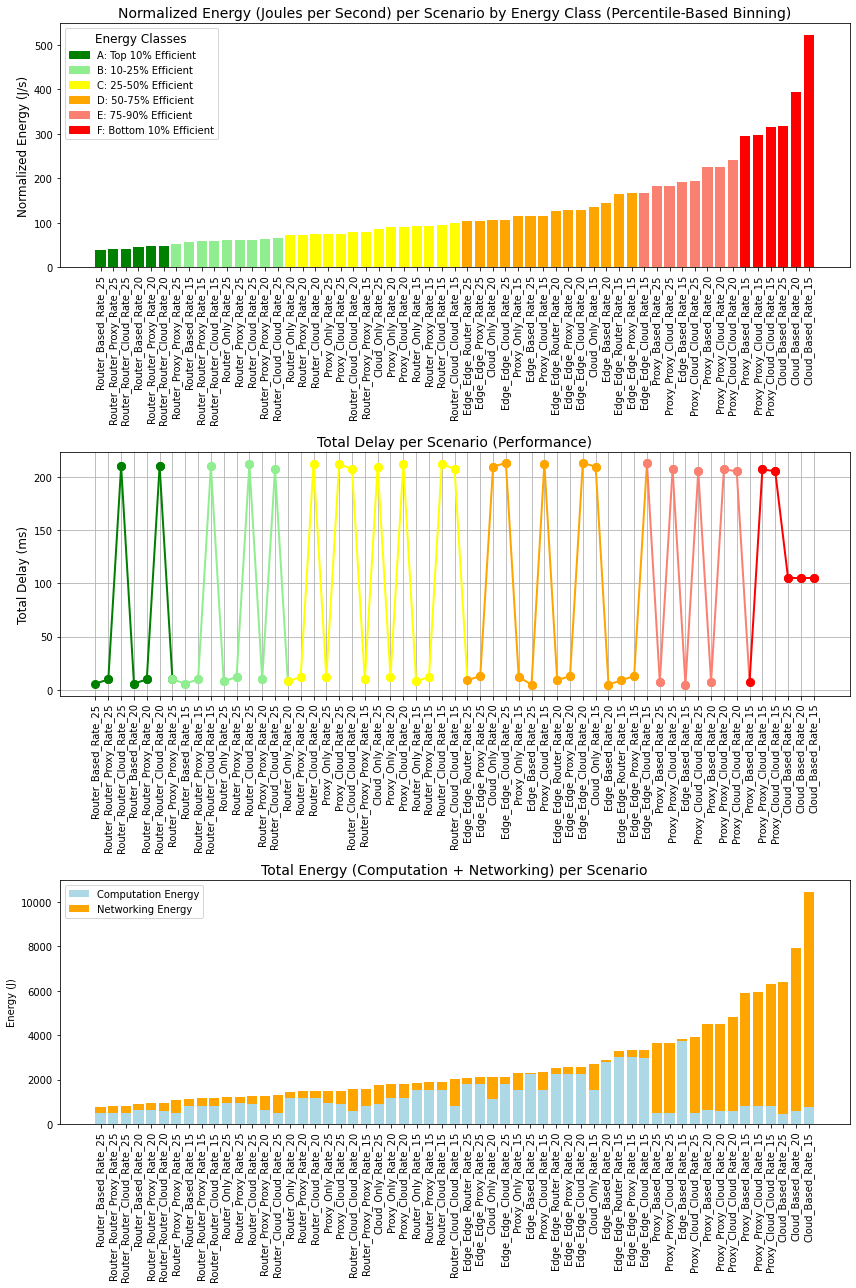

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# Define the directory where the Excel files are stored and where you want to save the results
output_dir = '/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/Report_Saeedeh/Definig_labels_data_after_fixing_simulator_CCGRID/'

# Step 0: Reset all DataFrames to ensure no old data is being used
rate_15_df = pd.DataFrame()
rate_20_df = pd.DataFrame()
rate_25_df = pd.DataFrame()
merged_df = pd.DataFrame()

# Step 1: Load the Excel files for the three rates
rate_15_df = pd.read_excel(os.path.join(output_dir, 'Rate_15_normalized_energy_per_scenario_J_per_sec_with_delay.xlsx'))
rate_20_df = pd.read_excel(os.path.join(output_dir, 'Rate_20_normalized_total_energy_per_scenario.xlsx'))
rate_25_df = pd.read_excel(os.path.join(output_dir, 'Rate_25_normalized_energy_per_scenario_J_per_sec_with_delay.xlsx'))

# Step 2: Add a column to each DataFrame to indicate the rate
rate_15_df['rate'] = 15
rate_20_df['rate'] = 20
rate_25_df['rate'] = 25

# Step 3: Standardize the column names in case they differ
rate_20_df = rate_20_df.rename(columns={'Normalized Energy (J/s)': 'normalized_energy_per_sec'})

# Step 4: Concatenate the three DataFrames into one
merged_df = pd.concat([rate_15_df, rate_20_df, rate_25_df], ignore_index=True)

# Step 5: Sort the merged DataFrame by 'normalized_energy_per_sec' in ascending order
merged_df = merged_df.sort_values(by='normalized_energy_per_sec').reset_index(drop=True)

merged_df.to_excel('Merged_Total_normalized_energy_per_scenario_J_per_sec_with_delay.xlsx', index=False)


# Step 6: Define energy classes for percentile-based approach
def assign_percentile_class(energy_value, percentile_thresholds):
    if energy_value <= percentile_thresholds[0]:
        return 'A'
    elif percentile_thresholds[0] < energy_value <= percentile_thresholds[1]:
        return 'B'
    elif percentile_thresholds[1] < energy_value <= percentile_thresholds[2]:
        return 'C'
    elif percentile_thresholds[2] < energy_value <= percentile_thresholds[3]:
        return 'D'
    elif percentile_thresholds[3] < energy_value <= percentile_thresholds[4]:
        return 'E'
    else:
        return 'F'

# Step 7: Calculate percentiles for all combined rates
percentile_thresholds = np.percentile(merged_df['normalized_energy_per_sec'], [10, 25, 50, 75, 90])

# Step 8: Assign energy classes using the percentile approach
merged_df['energy_class_percentile'] = merged_df['normalized_energy_per_sec'].apply(assign_percentile_class, args=(percentile_thresholds,))

# Step 9: Save the combined DataFrame to an Excel file in the same output directory
output_excel_path = os.path.join(output_dir, 'merged_normalized_energy_with_classes_sorted.xlsx')
merged_df.to_excel(output_excel_path, index=False)

# Step 10: Define the color map for energy classes
color_map = {
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'salmon', 'F': 'red', 'G': 'darkred'
}

# Create the figure with three subplots: one for energy class (bar chart), one for total delay (line chart), and one for stacked energy (computation + networking)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# ----- Plot 1: Energy class chart -----
colors = merged_df['energy_class_percentile'].map(color_map)
ax1.bar(merged_df['scenario'], merged_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class (Percentile-Based Binning)', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)

# Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label='A: Top 10% Efficient'),
    mpatches.Patch(color='lightgreen', label='B: 10-25% Efficient'),
    mpatches.Patch(color='yellow', label='C: 25-50% Efficient'),
    mpatches.Patch(color='orange', label='D: 50-75% Efficient'),
    mpatches.Patch(color='salmon', label='E: 75-90% Efficient'),
    mpatches.Patch(color='red', label='F: Bottom 10% Efficient')
]
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) chart -----
# Plot the delay using the colors based on energy class and also connect the lines
for i in range(len(merged_df) - 1):
    ax2.plot([i, i + 1], [merged_df['total_delay'].iloc[i], merged_df['total_delay'].iloc[i + 1]],
             color=colors.iloc[i], marker='o', markersize=8, linestyle='-', linewidth=2)
# Plot the last point separately
ax2.plot(len(merged_df) - 1, merged_df['total_delay'].iloc[-1], color=colors.iloc[-1], marker='o', markersize=8)
ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.grid(True)

# ----- Plot 3: Stacked Energy Chart (Computation + Networking) -----
computation_energy = merged_df['total_computation_energy']
networking_energy = merged_df['total_networking_energy']
ax3.bar(merged_df['scenario'], computation_energy, label='Computation Energy', color='lightblue')
ax3.bar(merged_df['scenario'], networking_energy, bottom=computation_energy, label='Networking Energy', color='orange')
ax3.set_title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
ax3.set_ylabel('Energy (J)')
ax3.legend()

# ----- Set X-axis labels for all charts -----
ax1.set_xticks(range(len(merged_df['scenario'])))
ax1.set_xticklabels(merged_df['scenario'], rotation=90)
ax2.set_xticks(range(len(merged_df['scenario'])))
ax2.set_xticklabels(merged_df['scenario'], rotation=90)
ax3.set_xticks(range(len(merged_df['scenario'])))
ax3.set_xticklabels(merged_df['scenario'], rotation=90)

# Ensure all plots fit well
plt.tight_layout()

# Save the combined plot with three charts in the same output directory
output_chart_combined = os.path.join(output_dir, 'combined_energy_performance_charts_percentile.png')
plt.savefig(output_chart_combined)

# Show the plot
plt.show()


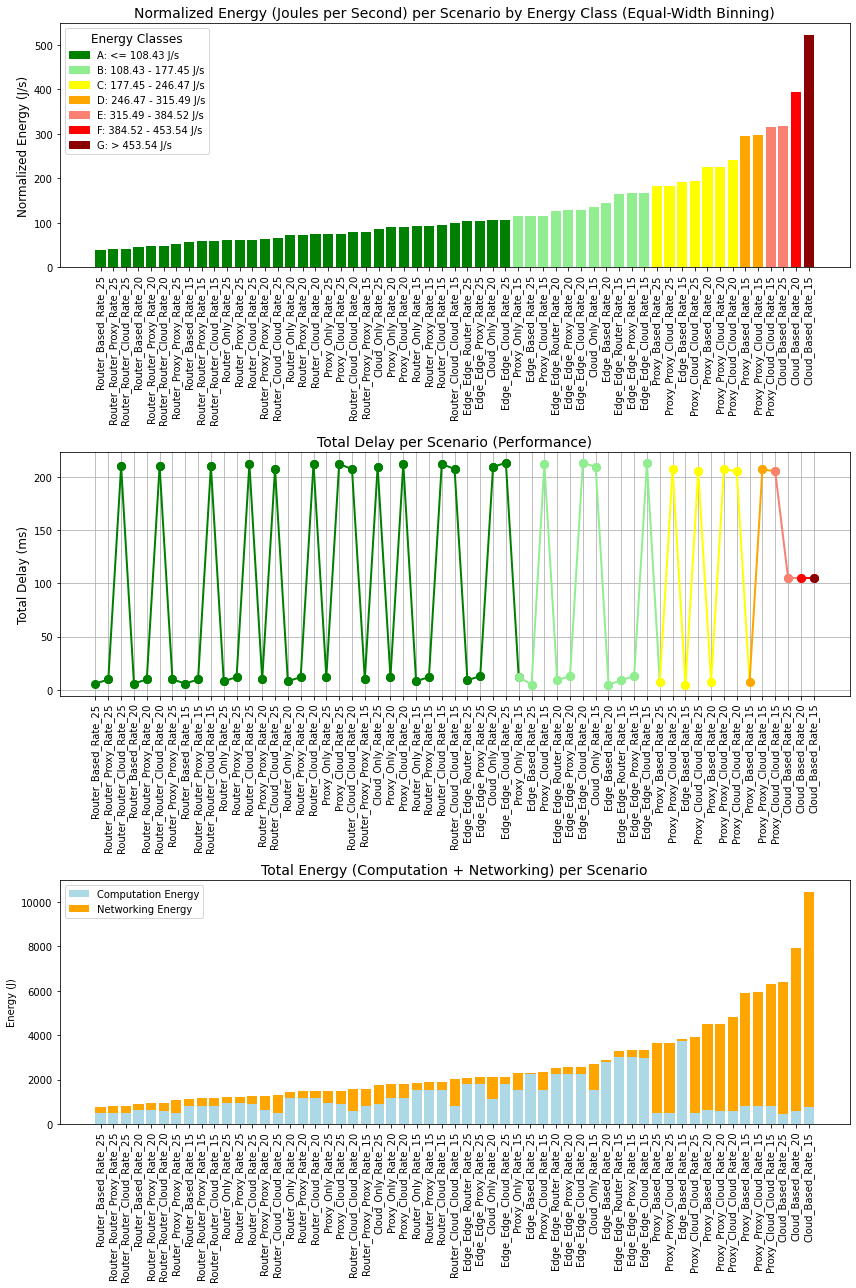

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# Directory where the Excel files are stored and where you want to save the results
output_dir = '/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/Report_Saeedeh/Definig_labels_data_after_fixing_simulator_CCGRID/'

# Step 0: Reset all DataFrames to ensure no old data is being used
rate_15_df = pd.DataFrame()
rate_20_df = pd.DataFrame()
rate_25_df = pd.DataFrame()
merged_df = pd.DataFrame()

# Step 1: Load the Excel files for the three rates
rate_15_df = pd.read_excel(os.path.join(output_dir, 'Rate_15_normalized_energy_per_scenario_J_per_sec_with_delay.xlsx'))
rate_20_df = pd.read_excel(os.path.join(output_dir, 'Rate_20_normalized_total_energy_per_scenario.xlsx'))
rate_25_df = pd.read_excel(os.path.join(output_dir, 'Rate_25_normalized_energy_per_scenario_J_per_sec_with_delay.xlsx'))

# Step 2: Add a column to each DataFrame to indicate the rate
rate_15_df['rate'] = 15
rate_20_df['rate'] = 20
rate_25_df['rate'] = 25

# Step 3: Standardize the column names in case they differ
rate_20_df = rate_20_df.rename(columns={'Normalized Energy (J/s)': 'normalized_energy_per_sec'})

# Step 4: Concatenate the three DataFrames into one
merged_df = pd.concat([rate_15_df, rate_20_df, rate_25_df], ignore_index=True)

# Step 5: Sort the merged DataFrame by 'normalized_energy_per_sec' in ascending order
merged_df = merged_df.sort_values(by='normalized_energy_per_sec').reset_index(drop=True)

# Step 6: Define energy classes for equal-width approach
def assign_equal_width_class(energy_value, min_energy, max_energy, num_classes=7):
    interval_size = (max_energy - min_energy) / num_classes
    class_boundaries = [min_energy + i * interval_size for i in range(num_classes + 1)]
    
    if energy_value <= class_boundaries[1]:
        return 'A'
    elif class_boundaries[1] < energy_value <= class_boundaries[2]:
        return 'B'
    elif class_boundaries[2] < energy_value <= class_boundaries[3]:
        return 'C'
    elif class_boundaries[3] < energy_value <= class_boundaries[4]:
        return 'D'
    elif class_boundaries[4] < energy_value <= class_boundaries[5]:
        return 'E'
    elif class_boundaries[5] < energy_value <= class_boundaries[6]:
        return 'F'
    else:
        return 'G'

# Step 7: Calculate the min and max energy for all combined rates
min_energy = merged_df['normalized_energy_per_sec'].min()
max_energy = merged_df['normalized_energy_per_sec'].max()

# Step 8: Assign energy classes using the equal-width approach
merged_df['energy_class_equal_width'] = merged_df['normalized_energy_per_sec'].apply(assign_equal_width_class, args=(min_energy, max_energy))

# Step 9: Save the combined DataFrame to an Excel file in the same output directory
output_excel_path = os.path.join(output_dir, 'merged_normalized_energy_with_equal_width_classes_sorted_fixed.xlsx')
merged_df.to_excel(output_excel_path, index=False)

# Create the custom legend for equal-width bins with accurate boundaries
interval_size = (max_energy - min_energy) / 7
class_boundaries = [min_energy + i * interval_size for i in range(8)]  # 7 intervals, 8 boundaries

# Step 10: Define the color map and create a custom legend
color_map = {
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'salmon', 'F': 'red', 'G': 'darkred'
}

legend_patches = [
    mpatches.Patch(color='green', label=f'A: {class_boundaries[0]:.2f} - {class_boundaries[1]:.2f} J/s'),
    mpatches.Patch(color='lightgreen', label=f'B: {class_boundaries[1]:.2f} - {class_boundaries[2]:.2f} J/s'),
    mpatches.Patch(color='yellow', label=f'C: {class_boundaries[2]:.2f} - {class_boundaries[3]:.2f} J/s'),
    mpatches.Patch(color='orange', label=f'D: {class_boundaries[3]:.2f} - {class_boundaries[4]:.2f} J/s'),
    mpatches.Patch(color='salmon', label=f'E: {class_boundaries[4]:.2f} - {class_boundaries[5]:.2f} J/s'),
    mpatches.Patch(color='red', label=f'F: {class_boundaries[5]:.2f} - {class_boundaries[6]:.2f} J/s'),
    mpatches.Patch(color='darkred', label=f'G: {class_boundaries[6]:.2f} - {class_boundaries[7]:.2f} J/s')
]


# Create the figure with three subplots: one for energy class (bar chart), one for total delay (line chart), and one for stacked energy (computation + networking)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# ----- Plot 1: Energy class chart (Equal-Width) -----
colors = merged_df['energy_class_equal_width'].map(color_map)
bars1 = ax1.bar(merged_df['scenario'], merged_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class (Equal-Width Binning)', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)

# Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label=f'A: <= {min_energy + (max_energy - min_energy) / 7:.2f} J/s'),
    mpatches.Patch(color='lightgreen', label=f'B: {min_energy + (max_energy - min_energy) / 7:.2f} - {min_energy + 2 * (max_energy - min_energy) / 7:.2f} J/s'),
    mpatches.Patch(color='yellow', label=f'C: {min_energy + 2 * (max_energy - min_energy) / 7:.2f} - {min_energy + 3 * (max_energy - min_energy) / 7:.2f} J/s'),
    mpatches.Patch(color='orange', label=f'D: {min_energy + 3 * (max_energy - min_energy) / 7:.2f} - {min_energy + 4 * (max_energy - min_energy) / 7:.2f} J/s'),
    mpatches.Patch(color='salmon', label=f'E: {min_energy + 4 * (max_energy - min_energy) / 7:.2f} - {min_energy + 5 * (max_energy - min_energy) / 7:.2f} J/s'),
    mpatches.Patch(color='red', label=f'F: {min_energy + 5 * (max_energy - min_energy) / 7:.2f} - {min_energy + 6 * (max_energy - min_energy) / 7:.2f} J/s'),
    mpatches.Patch(color='darkred', label=f'G: > {min_energy + 6 * (max_energy - min_energy) / 7:.2f} J/s')
]
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) chart -----
# Plot the delay using the colors based on energy class and also connect the lines
for i in range(len(merged_df) - 1):
    ax2.plot([i, i + 1], [merged_df['total_delay'].iloc[i], merged_df['total_delay'].iloc[i + 1]],
             color=colors.iloc[i], marker='o', markersize=8, linestyle='-', linewidth=2)
# Plot the last point separately
ax2.plot(len(merged_df) - 1, merged_df['total_delay'].iloc[-1], color=colors.iloc[-1], marker='o', markersize=8)
ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.grid(True)

# ----- Plot 3: Stacked Energy Chart (Computation + Networking) -----
computation_energy = merged_df['total_computation_energy']
networking_energy = merged_df['total_networking_energy']
bars3 = ax3.bar(merged_df['scenario'], computation_energy, label='Computation Energy', color='lightblue')
bars3 = ax3.bar(merged_df['scenario'], networking_energy, bottom=computation_energy, label='Networking Energy', color='orange')
ax3.set_title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
ax3.set_ylabel('Energy (J)')
ax3.legend()

# ----- Set X-axis labels for all charts -----
# Manually set the X-axis ticks and labels for each subplot
ax1.set_xticks(range(len(merged_df['scenario'])))
ax1.set_xticklabels(merged_df['scenario'], rotation=90)
ax2.set_xticks(range(len(merged_df['scenario'])))
ax2.set_xticklabels(merged_df['scenario'], rotation=90)
ax3.set_xticks(range(len(merged_df['scenario'])))
ax3.set_xticklabels(merged_df['scenario'], rotation=90)

# Ensure all plots fit well
plt.tight_layout()

# Save the combined plot with three charts in the same output directory
output_chart_combined = os.path.join(output_dir, 'combined_energy_performance_charts_equal_width_fixed.png')
plt.savefig(output_chart_combined)

# Show the plot
plt.show()


                       scenario  normalized_energy_per_sec   
0          Router_Based_Rate_25                  39.406509  \
1   Router_Router_Proxy_Rate_25                  40.168195   
2   Router_Router_Cloud_Rate_25                  40.726824   
3          Router_Based_Rate_20                  46.065105   
4   Router_Router_Proxy_Rate_20                  47.007136   
5   Router_Router_Cloud_Rate_20                  47.676771   
6    Router_Proxy_Proxy_Rate_25                  53.100372   
7          Router_Based_Rate_15                  57.134867   
8   Router_Router_Proxy_Rate_15                  58.376273   
9   Router_Router_Cloud_Rate_15                  59.229295   
10          Router_Only_Rate_25                  60.689075   
11         Router_Proxy_Rate_25                  61.450761   
12         Router_Cloud_Rate_25                  62.009389   
13   Router_Proxy_Proxy_Rate_20                  63.169070   
14   Router_Cloud_Cloud_Rate_25                  65.479213   
15      

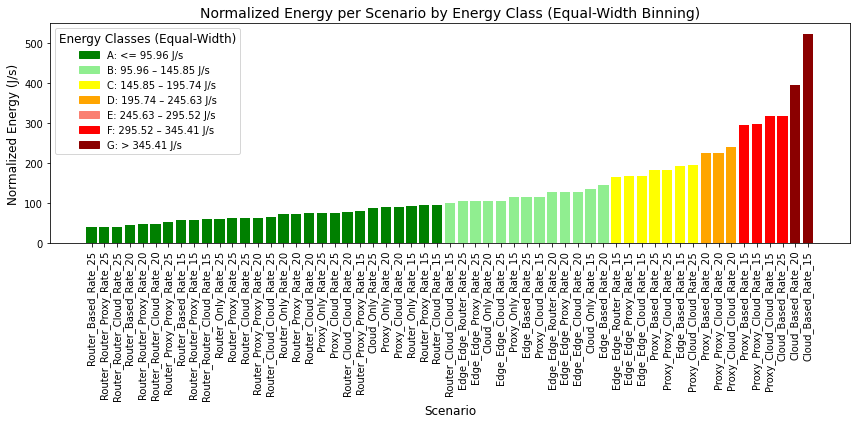

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# Assuming the data is already loaded as a DataFrame 'merged_df'
# If not, load the data from the Excel file (adjust the file path accordingly)
output_dir = '/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/Report_Saeedeh/Definig_labels_data_after_fixing_simulator_CCGRID/'
merged_df =pd.DataFrame()
merged_df = pd.read_excel(os.path.join(output_dir, 'Merged_Total_normalized_energy_per_scenario_J_per_sec_with_delay.xlsx'))

# Step 1: Define the equal-width classification ranges
def assign_equal_width_class(energy_value):
    if energy_value <= 95.96:
        return 'A'
    elif 95.96 < energy_value <= 145.85:
        return 'B'
    elif 145.85 < energy_value <= 195.74:
        return 'C'
    elif 195.74 < energy_value <= 245.63:
        return 'D'
    elif 245.63 < energy_value <= 295.52:
        return 'E'
    elif 295.52 < energy_value <= 345.41:
        return 'F'
    else:
        return 'G'

# Step 2: Apply the equal-width classification to the normalized energy column for all rates
merged_df['energy_class_equal_width'] = merged_df['normalized_energy_per_sec'].apply(assign_equal_width_class)

# Step 3: Display the updated DataFrame with energy classes for verification
print(merged_df[['scenario', 'normalized_energy_per_sec', 'energy_class_equal_width']])

# Step 4: Save the result to a new Excel file
output_excel_path = os.path.join(output_dir, 'combined_energy_with_equal_width_classes.xlsx')
merged_df.to_excel(output_excel_path, index=False)

# Step 5: Visualize the energy class distribution using a bar chart
colors = merged_df['energy_class_equal_width'].map({
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'salmon', 'F': 'red', 'G': 'darkred'
})

plt.figure(figsize=(12, 6))
bars = plt.bar(merged_df['scenario'], merged_df['normalized_energy_per_sec'], color=colors)

# Step 6: Create a custom legend based on the energy class
legend_patches = [
    mpatches.Patch(color='green', label='A: <= 95.96 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 95.96 – 145.85 J/s'),
    mpatches.Patch(color='yellow', label='C: 145.85 – 195.74 J/s'),
    mpatches.Patch(color='orange', label='D: 195.74 – 245.63 J/s'),
    mpatches.Patch(color='salmon', label='E: 245.63 – 295.52 J/s'),
    mpatches.Patch(color='red', label='F: 295.52 – 345.41 J/s'),
    mpatches.Patch(color='darkred', label='G: > 345.41 J/s')
]

# Step 7: Add the legend to the chart
plt.legend(handles=legend_patches, title='Energy Classes (Equal-Width)', fontsize=10, title_fontsize=12)

# Formatting the chart
plt.title('Normalized Energy per Scenario by Energy Class (Equal-Width Binning)', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Normalized Energy (J/s)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Step 8: Save the chart as a PNG file
output_chart_path = os.path.join(output_dir, 'equal_width_classification_chart_all_rates.png')
plt.savefig(output_chart_path)

# Step 9: Display the plot
plt.show()
